# Mini challenge - NPM3D

## Imports

In [1]:
import warnings
from datetime import datetime
from typing import Tuple

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from src import (
    FeaturesExtractor,
    timeit,
    checkpoint,
    write_ply,
    smooth_labels,
)

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# paths of the training and test files
training_path = "./data/training"
test_path = "./data/test"
# choosing MiniLille1 as our validation set because it is the smallest
validation_point_cloud = "MiniLille1.ply"

In [3]:
features_extractor = FeaturesExtractor()

## Model selection

In [4]:
def choose_model(model: str):
    if model == "sklearn":
        return RandomForestClassifier()
    elif model == "lgbm":
        return LGBMClassifier(num_leaves=167, reg_lambda=0.1)
    elif model == "xgboost":
        return XGBClassifier()
    else:
        raise ValueError("Incorrect model name passed")

In [5]:
model_name = "lgbm"  # @param ["lgbm", "sklearn", "xgboost"]
clf = choose_model(model_name)

## Pipelines

In [26]:
@timeit
def save_prediction(
    model,
    test_data_path: str,
    file_path: str = f"submissions/{model_name}-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.txt",
    enable_smoothing: bool = True,
) -> None:
    """
    Saves the prediction made by a given model on the test features in a txt file.
    """
    timer = checkpoint()
    test_features = features_extractor.extract_features_no_label(test_data_path)
    timer("Time spent computing test features")

    predicted_labels = model.predict(test_features)
    timer("Time spent on test prediction")

    if enable_smoothing:
        aggregated_test_features = features_extractor.aggregate_features(test_features)
        timer("Time spent aggregating the features over the scales")
        point_cloud = features_extractor.extract_point_cloud_no_label(test_path)
        smooth_labels(
            point_cloud,
            predicted_labels,
            0.2,
            len(features_extractor.label_names),
            aggregated_test_features[:, 2],
            aggregated_test_features[:, 5],
            aggregated_test_features[:, 13],
            aggregated_test_features[:, 15],
            aggregated_test_features[:, 20],
            verbose=True,
            thresholds={
                "omnivariance": 30,
                "planarity": 75,
                "neighborhood_size": 300,
                "moment_x_sq": 500,
                "moment_y_sq": 500,
            }
        )
        timer("Time spent smoothing the features")

    assert predicted_labels.shape[0] == 3079187, "Incorrect number of predictions"

    if model_name == "xgboost":
        predicted_labels += 1

    np.savetxt(
        file_path,
        predicted_labels,
        fmt="%d",
    )
    timer(f"Time spent writing results on {file_path}")

In [7]:
@timeit
def test(
    predicted_labels: np.ndarray,
    test_labels: np.ndarray,
    point_cloud: np.ndarray,
    file_path: str = f"submissions/point_clouds/{model_name}-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.ply",
) -> None:
    """
    Displays a few metrics to validate the model: accuracy, Jaccard score, confusion matrix.
    Also saves the point cloud with additional scalar fields containing the true and predicted labels to enable visualization of the errors.
    """
    print(f"Accuracy:      {accuracy_score(test_labels, predicted_labels) * 100:.2f}%")
    print(
        f"Jaccard score: {jaccard_score(test_labels, predicted_labels, average='micro'):.4f}"
    )
    ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels)

    if len(point_cloud) == len(predicted_labels):
        print(f"Saving the point cloud under {file_path}")
        write_ply(
            file_path,
            [
                point_cloud,
                predicted_labels,
                test_labels,
            ],
            ["x", "y", "z", "predicted_label", "true_label"],
        )

In [8]:
feature_list = lambda x: [
    f"eigensum_{x}",
    f"eigen_square_sum_{x}",
    f"omnivariance_{x}",
    f"eigenentropy_{x}",
    f"linearity_{x}",
    f"planarity_{x}",
    f"sphericity_{x}",
    f"curvature_change_{x}",
    f"verticality_{x}",
    f"lin_verticality_{x}",
    f"horizontalityx_{x}",
    f"horizontalityy_{x}",
    f"moments_x1_{x}",
    f"moments_x2_{x}",
    f"moments_y1_{x}",
    f"moments_y2_{x}",
    f"moments_z1_{x}",
    f"moments_z2_{x}",
    f"vert_moments_1_{x}",
    f"vert_moments_2_{x}",
    f"neighborhood_sizes_{x}",
]

In [9]:
def plot_feature_importance(model, fig_size=(30, 60)) -> None:
    """
    Plots the feature importance for a LightGBM model.
    """
    plt.figure(figsize=fig_size)
    sns.set(font_scale=2)
    sns.barplot(
        x="Value",
        y="Feature",
        data=pd.DataFrame(
            {
                "Value": model.feature_importances_,
                "Feature": [
                    feature
                    for scale in range(features_extractor.n_scales)
                    for feature in feature_list(scale)
                ],
            }
        ).sort_values(by="Value", ascending=False),
    )
    plt.title("Model feature importance (averaged over folds)")
    plt.tight_layout()
    plt.show()

In [10]:
def plot_feature_score_by_class(
    features: np.ndarray, labels: np.ndarray, n_labels: int, sum_on_scales: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Plots the mean and std over the point cloud of each feature.
    If sum_on_scales is set to True, the features will be summed over the different subsampling scales.
    """
    n_scales = features_extractor.n_scales
    means = np.zeros(
        (
            n_labels,
            features.shape[1] // n_scales if sum_on_scales else features.shape[1],
        )
    )
    stds = np.zeros(
        (
            n_labels,
            features.shape[1] // n_scales if sum_on_scales else features.shape[1],
        )
    )

    if sum_on_scales:
        features = features.reshape(
            (features.shape[0], features.shape[1] // n_scales, n_scales)
        ).sum(axis=-1)

    for label in range(1, n_labels):
        points_with_label = features[labels == label]
        means[label] = points_with_label.mean(axis=0)
        stds[label] = points_with_label.std(axis=0)

    return means, stds

## Experiments

## Testing the model with a validation set

The validation set is made either by one of the point clouds, or by splitting the aggregated point clouds randomly into training and validation.

### Loading the data

In [11]:
%%time
test_point_cloud = features_extractor.extract_point_clouds(
    training_path, validation_point_cloud
)[2]


Reading file MiniParis1.ply
1210261 elements available for class Ground
1071599 elements available for class Building
24787 elements available for class Poles
32396 elements available for class Pedestrians
50468 elements available for class Cars
1455156 elements available for class Vegetation

Reading file MiniLille1.ply
767722 elements available for class Ground
864939 elements available for class Building
5532 elements available for class Poles
0 elements available for class Pedestrians
114237 elements available for class Cars
104182 elements available for class Vegetation

Reading file MiniLille2.ply
1074040 elements available for class Ground
1000935 elements available for class Building
13094 elements available for class Poles
0 elements available for class Pedestrians
96132 elements available for class Cars
261365 elements available for class Vegetation
CPU times: user 229 ms, sys: 86 ms, total: 315 ms
Wall time: 382 ms


In [12]:
%%time
use_whole_point_cloud_for_validation = True
train_features, train_labels = features_extractor.extract_features(training_path)

if use_whole_point_cloud_for_validation:
    print(f"Using point cloud {validation_point_cloud} as validation set.")
    # the line below does not require computing the features again since they are cached
    X_train, y_train, X_val, y_val = features_extractor.extract_features(
        training_path, validation_point_cloud
    )
else:
    print(f"Splitting the training point clouds between training and validation.")
    X_train, X_val, y_train, y_val = train_test_split(
        train_features, train_labels, test_size=0.2, random_state=42
    )


Reading file MiniParis1.ply
Using cached features and labels

Reading file MiniLille1.ply
Using cached features and labels

Reading file MiniLille2.ply
Using cached features and labels
Using point cloud MiniLille1.ply as validation set.

Reading file MiniParis1.ply
Using cached features and labels

Reading file MiniLille1.ply
Using cached features and labels

Reading file MiniLille2.ply
Using cached features and labels
CPU times: user 152 ms, sys: 1.47 s, total: 1.62 s
Wall time: 2.79 s


In [13]:
if model_name == "xgboost":
    y_train -= 1
    y_train = y_train.astype(int)
    y_val -= 1
    y_val = y_val.astype(int)

### Data analysis

In [14]:
feature_means, feature_stds = plot_feature_score_by_class(
    train_features, train_labels, len(features_extractor.label_names)
)

In [15]:
feature_means

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.06459808e+00, 1.08304813e+00, 1.53991964e+01, 2.11685017e+00,
        5.14311930e-02, 5.62996507e+01, 1.07220388e+00, 9.64231690e+01,
        2.59797058e+00, 2.69965142e-01, 1.06574147e+02, 2.08663637e+00,
        1.30003436e+00, 1.21169208e+02, 1.10138672e+00, 3.25139859e+02,
        4.10681608e+01, 2.02665113e+01, 1.10886281e+04, 1.89773588e+00,
        2.41674966e+02],
       [1.08839963e+00, 1.51136035e+00, 1.36315176e+01, 2.27095639e+00,
        3.72014337e-01, 5.33816020e+01, 1.60971665e+00, 1.03627161e+02,
        1.82991410e+00, 1.53444343e+00, 1.26628763e+02, 2.54341572e+00,
        1.7601

In [16]:
feature_stds

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [3.43670335e-02, 1.19182274e-01, 5.57106929e+00, 5.23815465e-02,
        5.27582335e-02, 1.81174164e+01, 1.13712426e-01, 2.37134591e+01,
        7.26692369e-02, 1.40385123e-01, 2.57298815e+01, 9.69699383e-02,
        8.91451332e-02, 2.86580736e+01, 9.06681023e-02, 3.71507165e+01,
        7.26867454e+01, 1.66661154e+00, 3.48388452e+03, 1.84044676e-01,
        3.98561620e+01],
       [5.65775482e-02, 2.74818042e-01, 5.55545590e+00, 3.46786727e-01,
        2.12900824e-01, 2.27011195e+01, 3.51426528e-01, 3.39695382e+01,
        2.20024775e-01, 4.22784698e-01, 3.11006367e+01, 3.18326509e-01,
        2.5365

In [17]:
save_point_cloud_with_features = False  # @param {type:"boolean"}

if save_point_cloud_with_features:
    assert (
        use_whole_point_cloud_for_validation
    ), "You are not using a separate point cloud for validation"
    aggregated_features = features_extractor.aggregate_features(X_val)
    assert (
        test_point_cloud.shape[0] == aggregated_features.shape[0]
    ), "Not as many points as feature points"
    write_ply(
        "agg_feats.ply",
        [
            test_point_cloud,
            aggregated_features[:, 2],
            aggregated_features[:, 5],
            aggregated_features[:, 13],
            aggregated_features[:, 15],
            aggregated_features[:, 20],
        ],
        [
            "x",
            "y",
            "z",
            "omnivariance",
            "planarity",
            "neighborhood_size",
            "moment_x_sq",
            "moment_y_sq",
        ],
    )

### Training the model

In [16]:
%%time
clf.fit(X_train, y_train)

CPU times: user 4min 20s, sys: 16.1 s, total: 4min 37s
Wall time: 1min 8s


LGBMClassifier(num_leaves=167, reg_lambda=0.1)

In [17]:
print(f"Training set score: {clf.score(X_train, y_train):.4f}")
print(f"Test set score: {clf.score(X_val, y_val):.4f}")

Training set score: 1.0000
Test set score: 0.8819


We can try to detect overfitting here; if the score is low on the test set and high on the training set our model is most likely overfitting on the training set. Note that we only train on two out of the three point clouds, and will train on all three before submitting our result.

### Testing the model

Accuracy:      88.19%
Jaccard score: 0.7887
Saving the point cloud under submissions/point_clouds/lgbm-2023_03_09-17_06.ply
Function test took 0.35 seconds
CPU times: user 16.8 s, sys: 105 ms, total: 16.9 s
Wall time: 3.06 s


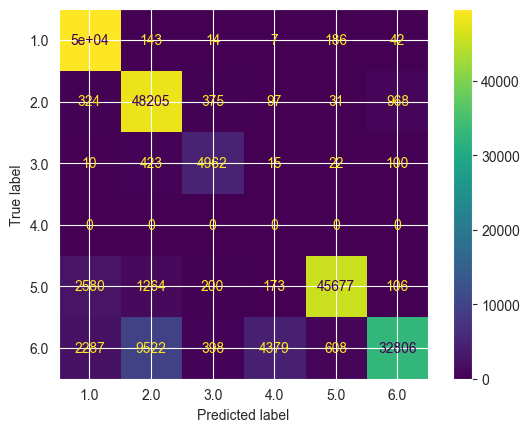

In [18]:
%%time
prediction = clf.predict(X_val)
test(prediction, y_val, test_point_cloud)

### Evaluating the smoothing method

#### Measuring the impact of the neighborhood radius



Radius: 0.2
Function smooth_labels took 505.37 seconds
Accuracy:      93.29%
Jaccard score: 0.8743
Saving the point cloud under submissions/point_clouds/lgbm_smooth-2023_03_07-22_28.ply
Function test took 0.24 seconds


Radius: 0.3
Function smooth_labels took 164.58 seconds
Accuracy:      93.83%
Jaccard score: 0.8839
Saving the point cloud under submissions/point_clouds/lgbm_smooth-2023_03_07-22_31.ply
Function test took 0.19 seconds


Radius: 0.4
Function smooth_labels took 104.36 seconds
Accuracy:      86.26%
Jaccard score: 0.7583
Saving the point cloud under submissions/point_clouds/lgbm_smooth-2023_03_07-22_33.ply
Function test took 0.19 seconds
CPU times: user 13min 14s, sys: 27.9 s, total: 13min 42s
Wall time: 13min 2s


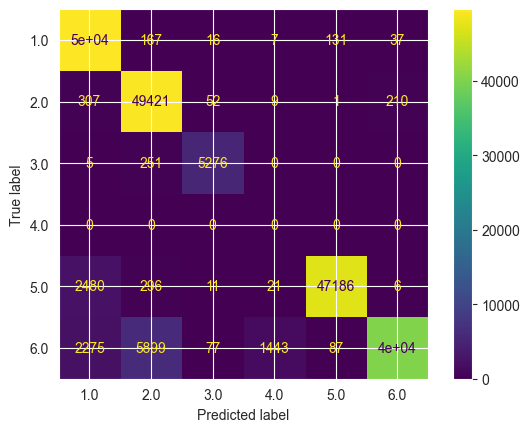

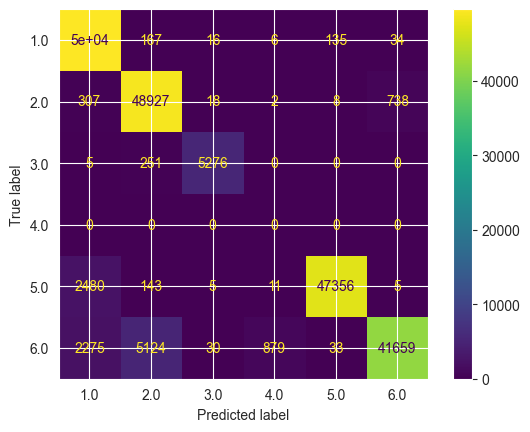

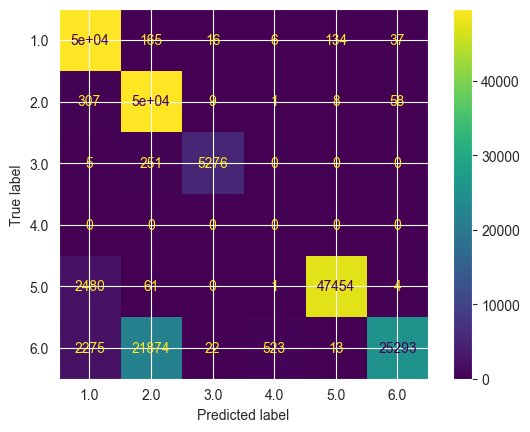

In [26]:
%%time
run_radius_comparison = False  # @param {type:"boolean"}

if run_radius_comparison:
    for radius in [0.2, 0.3, 0.4]:
        print(f"\n\nRadius: {radius}")
        prediction = clf.predict(X_val)
        aggregated_features = features_extractor.aggregate_features(X_val)
        smooth_labels(
            test_point_cloud,
            prediction,
            radius,
            len(features_extractor.label_names),
            aggregated_features[:, 2],
            aggregated_features[:, 5],
            aggregated_features[:, 13],
            aggregated_features[:, 15],
            aggregated_features[:, 20],
            thresholds={
                "omnivariance": 10,
                "planarity": 40,
                "neighborhood_size": 160,
                "moment_x_sq": 200,
                "moment_y_sq": 180,
            },
        )
        test(
            prediction,
            y_val,
            test_point_cloud,
            file_path=f"submissions/point_clouds/{model_name}_smooth-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.ply",
        )

#### Measuring the impact of the threshold

In [19]:
%%time
run_thresholds_comparison = True  # @param {type:"boolean"}

if run_thresholds_comparison:
    aggregated_features = features_extractor.aggregate_features(X_val)
    for omnivariance_threshold in [20, 30]:
        for planarity_threshold in [55, 65]:
            for neighborhood_size_threshold in [200, 300]:
                print(
                    f"Omnivariance: {omnivariance_threshold}, planarity: {planarity_threshold}, neighborhood size: {neighborhood_size_threshold}"
                )
                prediction = clf.predict(X_val)
                smooth_labels(
                    test_point_cloud,
                    prediction,
                    0.2,
                    len(features_extractor.label_names),
                    aggregated_features[:, 2],
                    aggregated_features[:, 5],
                    aggregated_features[:, 13],
                    aggregated_features[:, 15],
                    aggregated_features[:, 20],
                    thresholds={
                        "omnivariance": omnivariance_threshold,
                        "planarity": planarity_threshold,
                        "neighborhood_size": neighborhood_size_threshold,
                        "moment_x_sq": 400,
                        "moment_y_sq": 400,
                    },
                )
                test(
                    prediction,
                    y_val,
                    test_point_cloud,
                    file_path=f"submissions/point_clouds/{model_name}_smooth-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.ply",
                )

Omnivariance: 20, planarity: 55, neighborhood size: 200


KeyboardInterrupt: 

In [22]:
prediction = clf.predict(X_val)
aggregated_features = features_extractor.aggregate_features(X_val)
smooth_labels(
    test_point_cloud,
    prediction,
    0.2,
    len(features_extractor.label_names),
    aggregated_features[:, 2],
    aggregated_features[:, 5],
    aggregated_features[:, 13],
    aggregated_features[:, 15],
    aggregated_features[:, 20],
    verbose=True,
    thresholds={
        "omnivariance": 30,
        "planarity": 75,
        "neighborhood_size": 300,
        "moment_x_sq": 500,
        "moment_y_sq": 500,
    }
)

150723 points left unvisited.
1 points visited.

150722 points left unvisited.
1 points visited.

150721 points left unvisited.
2 points visited.

150719 points left unvisited.
1 points visited.

150718 points left unvisited.
2 points visited.

150716 points left unvisited.
1 points visited.

150715 points left unvisited.
1 points visited.

150714 points left unvisited.
1 points visited.

150713 points left unvisited.
1 points visited.

150712 points left unvisited.
1 points visited.

150711 points left unvisited.
1 points visited.

150710 points left unvisited.
1 points visited.

150709 points left unvisited.
1 points visited.

150708 points left unvisited.
1 points visited.

150707 points left unvisited.
43 points visited.

150664 points left unvisited.
1 points visited.

150663 points left unvisited.
1 points visited.

150662 points left unvisited.
1 points visited.

150661 points left unvisited.
1 points visited.

150660 points left unvisited.
1 points visited.

150659 points left 

Accuracy:      96.07%
Jaccard score: 0.9243
Saving the point cloud under submissions/point_clouds/lgbm_smooth-2023_03_09-18_26.ply
Function test took 0.31 seconds


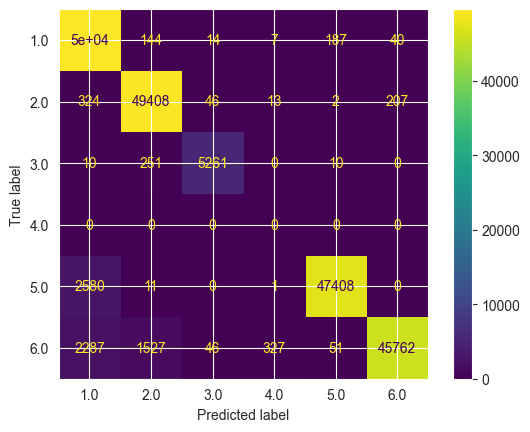

In [23]:
test(
    prediction,
    y_val,
    test_point_cloud,
    file_path=f"submissions/point_clouds/{model_name}_smooth-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.ply",
)

#### Cross validation on the model parameters

In [28]:
perform_cross_val = False  # @param {type:"boolean"}

if perform_cross_val:
    from sklearn.model_selection import GridSearchCV, StratifiedKFold

    gkf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(
        X=X_train, y=y_train
    )

    if model_name == "lgbm":
        param_grid = {
            "learning_rate": [1e-2],
            "num_leaves": [217],
            # "reg_alpha": [0.],
            "reg_lambda": [0.0, 0.5],
            # "min_child_samples": [18, 20],
            # "min_child_weight": [5e-4, 1e-3],
        }
    elif model_name == "sklearn":
        param_grid = {
            "learning_rate": [1e-2],
            "num_leaves": [103, 147],
        }
    # 0.991, 217
    gsearch = GridSearchCV(
        estimator=clf, param_grid=param_grid, cv=gkf, n_jobs=1, verbose=42
    )
    lgb_model = gsearch.fit(X=X_train, y=y_train)

    print(lgb_model.best_params_, lgb_model.best_score_)

## Training the model on all three point clouds

In [24]:
%%time
clf.fit(train_features, train_labels)

CPU times: user 7min 2s, sys: 22 s, total: 7min 24s
Wall time: 1min 44s


LGBMClassifier(num_leaves=167, reg_lambda=0.1)

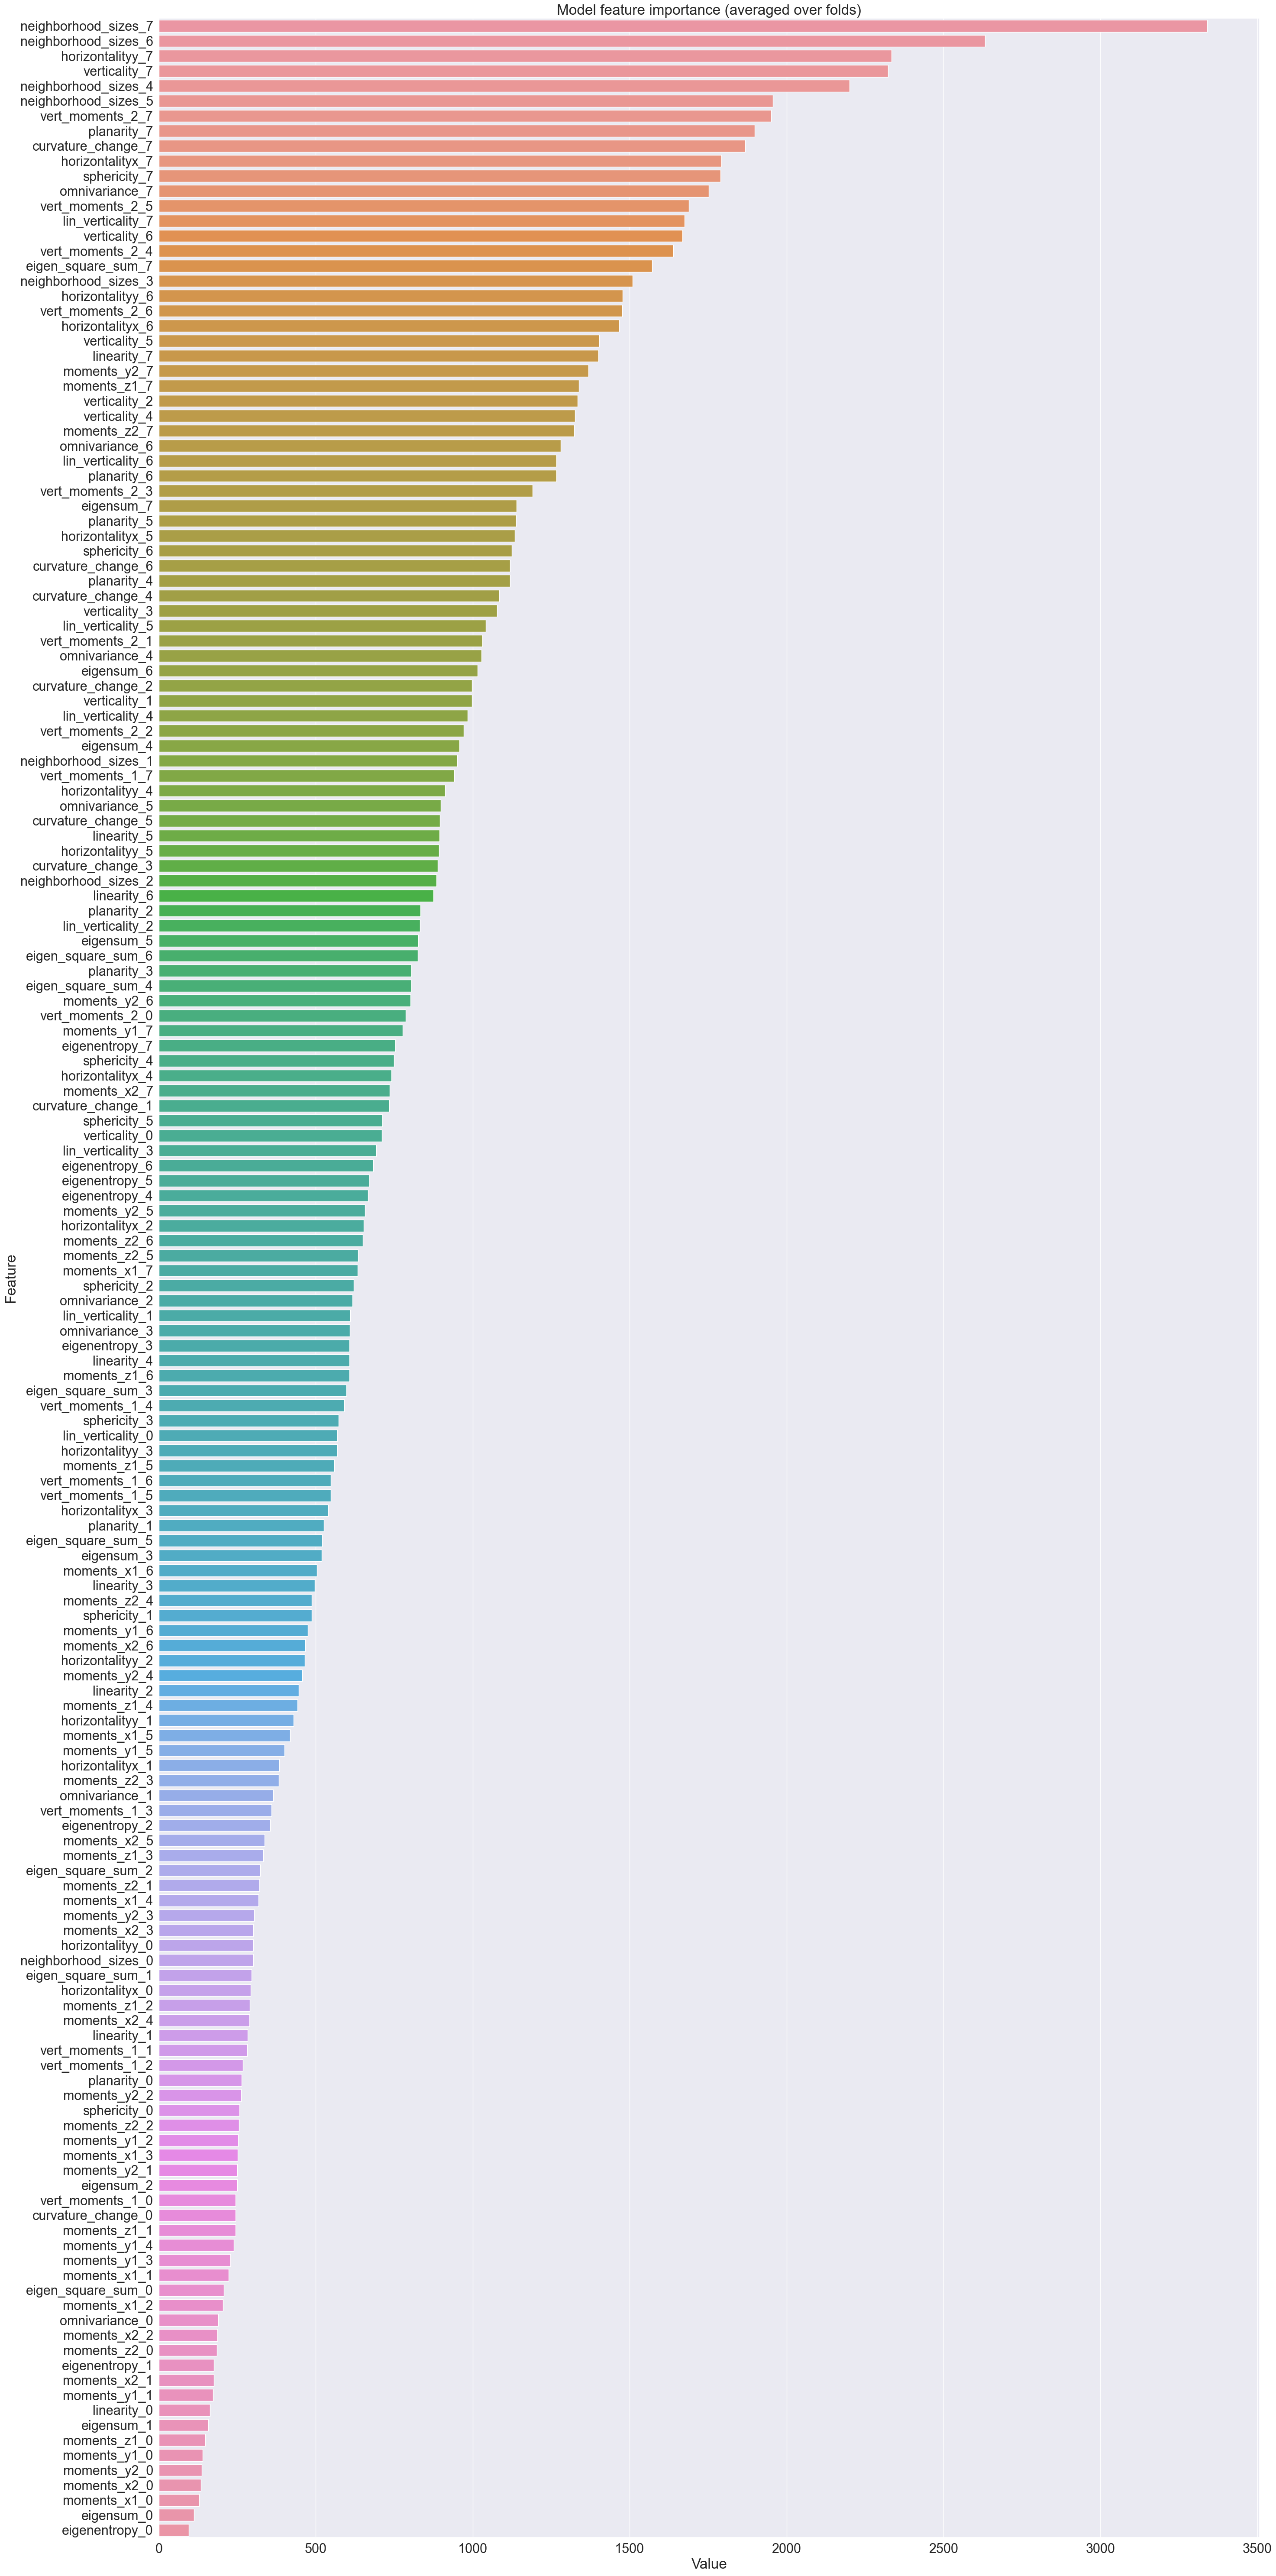

In [30]:
plot_feature_importance(clf)

In [27]:
save_prediction(clf, test_path)


Reading file MiniDijon9.ply
Using cached features
Time spent computing test features: 4038.79 seconds
Time spent on test prediction: 32.24 seconds
Time spent aggregating the features over the scales: 2.02 seconds

Reading file MiniDijon9.ply
1743743 points left unvisited.
457330 points visited.

1286413 points left unvisited.
686711 points visited.

599702 points left unvisited.
6176 points visited.

593526 points left unvisited.
1753 points visited.

591773 points left unvisited.
3199 points visited.

588574 points left unvisited.
2513 points visited.

586061 points left unvisited.
7749 points visited.

578312 points left unvisited.
20515 points visited.

557797 points left unvisited.
45576 points visited.

512221 points left unvisited.
8040 points visited.

504181 points left unvisited.
9511 points visited.

494670 points left unvisited.
4243 points visited.

490427 points left unvisited.
10741 points visited.

479686 points left unvisited.
1983 points visited.

477703 points left u